## Machine Learning
https://www.kaggle.com/datasets/aldinwhyudii/student-depression-and-lifestyle-100k-data

In [44]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')


In [ ]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# 10.000 zufällige negative Stichproben ziehen
not_depressed_sample = not_depressed.sample(n=10062, random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])
# balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True) 

# Aufteilen in Merkmale und Zielvariable und löschen von Student_ID
data = balanced_dataset.loc[:, 'Age':'Stress_Level']
target = balanced_dataset['Depression']

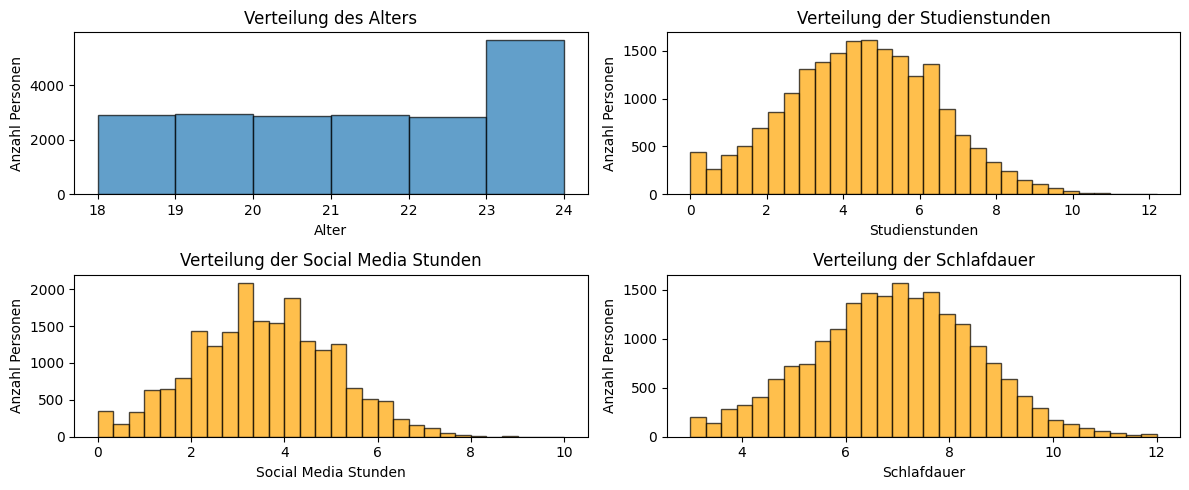

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.hist(balanced_dataset['Age'], bins=6, edgecolor='black', alpha=0.7)
plt.title('Verteilung des Alters')
plt.xlabel('Alter')
plt.ylabel('Anzahl Personen')

plt.subplot(2, 2, 2)
plt.hist(balanced_dataset['Study_Hours'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Verteilung der Studienstunden')
plt.xlabel('Studienstunden')
plt.ylabel('Anzahl Personen')

plt.subplot(2, 2, 3)
plt.hist(balanced_dataset['Social_Media_Hours'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Verteilung der Social Media Stunden')
plt.xlabel('Social Media Stunden')
plt.ylabel('Anzahl Personen')

plt.subplot(2, 2, 4)
plt.hist(balanced_dataset['Sleep_Duration'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Verteilung der Schlafdauer')
plt.xlabel('Schlafdauer')
plt.ylabel('Anzahl Personen')

plt.tight_layout()
plt.show()